In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np

train_image_dir = '/content/gdrive/My Drive/fashin-mnist/train-images-idx3-ubyte'
train_label_dir = '/content/gdrive/My Drive/fashin-mnist/train-labels-idx1-ubyte'
test_image_dir = '/content/gdrive/My Drive/fashin-mnist/t10k-images-idx3-ubyte'
test_label_dir = '/content/gdrive/My Drive/fashin-mnist/t10k-labels-idx1-ubyte'

N_CLASSES = 10
IMG_WIDTH = 28
IMG_HEIGHT = 28
N_CHANNELS = 1 #图片是灰度图
IMAGE_LABELS = ['T-shirt/top', 'Trousr', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



'''
加载图片数据集，将60000张图片分成两部分，第一部分55000张用于训练，
第二部分5000张用于校验
'''
def  load_data(load_type = 'train'):
  #构造两部分数据x对应图片，y对应标签
  if load_type == 'train':
    image_file = open(train_image_dir)
    image_data = np.fromfile(file = image_file, dtype = np.uint8)
    x = image_data[16:].reshape((60000, 28, 28, 1)).astype(np.float32)
    
    label_file = open(train_label_dir)
    label_data = np.fromfile(label_file, dtype = np.uint8)
    y = label_data[8:].reshape(60000).astype(np.int32)
    
    #把像素点的值转换到[0,1]之间
    x_train= x[: 55000] / 255.
    y_train = y[:55000]
    '''
    假设y_train[0] = 4,下面代码把y_train[0]变成一个向量
    [0, 0, 0, 0, 1.0, 0, 0, 0, 0, 0]
    '''
    y_train = (np.arange(N_CLASSES) == y_train[:, None]).astype(np.float32)
    
    x_valid = x[55000 :,] / 255.
    y_valid = y[55000 :,]
    y_valid = (np.arange(N_CLASSES) == y_valid[:, None]).astype(np.float32)
    return x_train, y_train, x_valid, y_valid
  elif load_type == 'test':
    image_file = open(test_image_dir)
    image_data = np.fromfile(file = image_file, dtype = np.uint8)
    x_test = image_data[16:].reshape((10000, 28 , 28, 1)).astype(np.float32)
    
    label_file = open(test_label_dir)
    label_data = np.fromfile(file = label_file, dtype = np.uint8)
    y_test = label_data[8:].reshape(10000).astype(np.int32)
    y_test = (np.arange(N_CLASSES) == y_test[:, None]).astype(np.float32)
    return x_test / 255., y_test
    

In [0]:
'''
根据公式（2）计算squash
'''
def  squash(vectors, name = None):
  with tf.name_scope(name, default_name = 'squash_op'):
    s_squared_norm = tf.reduce_sum(tf.square(vectors), axis=-2, keepdims = True)
    #tf.keras.backend.epsilon() = 1e-7，加上这个值是防止s_squared_norm为0时产生除0异常
    scale = s_squared_norm / (1. + s_squared_norm) / tf.sqrt(s_squared_norm + 
                                                            tf.keras.backend.epsilon())
    return scale * vectors

In [0]:
#胶囊层含有32个胶囊
MAPS_CAPS1 = 32
#图12-34胶囊层每个正方体对应的宽和高都是6
NCAPS_CAPS1 = MAPS_CAPS1*6*6
#胶囊层每个胶囊对上一层数据进行9*9分割后，识别结果为含有8个元素的向量
CAPS_DIM_CAPS1 = 8
#第二层胶囊层的胶囊个数
NCAPS_CAPS2 = 10
#第二层每个胶囊输出结果为含有16个元素的向量
CAPS_DIM_CAPS2 = 16

BATCH_SIZE = 128
ROUTING_ITERATIONS = 3
STDEV = 0.01
'''
根据路由流程，把上一层胶囊的输出结果传递给下一层胶囊
'''
def  routing(u):
  #把上一层编号为i的胶囊与下一层编号为j的胶囊之间的连接系数初始化为0
  b_ij = tf.zeros([BATCH_SIZE, NCAPS_CAPS1, NCAPS_CAPS2, 1, 1],
                 dtype = np.float32, name="b_ij")
  '''
  u是第二层卷积层的输出结果，它的格式为[BATCH_SIZE, 1152, 1, 8, 1], 其中1152对应’胶囊‘个数，
  其中后面的[8,1]对应胶囊输出向量，中间的1用于方便运算，下面代码将u扩展为[BATCH_SIZE, 1152, 10, 8, 1]
  '''
  u = tf.tile(u, [1, 1, b_ij.shape[2].value, 1, 1])
  #构造公式（1）所对应的W[i,j]其中i=1152, j = 10
  W = tf.get_variable('W', shape = (1, u.shape[1].value, b_ij.shape[2].value,
                                   u.shape[3].value, CAPS_DIM_CAPS2), dtype = tf.float32,
                     initializer = tf.random_normal_initializer(stddev = STDEV))
  #将W扩展为[BATCH_SIZE, 1152, 10, 8, 6]
  W = tf.tile(W, [BATCH_SIZE, 1, 1, 1, 1])
  #根据公式(1)上半部分计算u^
  u_hat = tf.matmul(W, u, transpose_a = True)
  '''
  由于u_hat_stopped用于计算c(i,j)，因为后者通过迭代运算而来，因此不参与到网络的参数调整中，
  因此网络用梯度下降法调整参数时，由u_hat参与迭代运算产生的变量都不能进行调整，
  所以要stop_greadient
  '''
  u_hat_stopped = tf.stop_gradient(u_hat, name = 'gradient_stop')
  
  #根据公式(1)第二部分计算Sj
  for r in range(ROUTING_ITERATIONS):
     with tf.variable_scope('iterations_' + str(r)):
      c_ij = tf.nn.softmax(b_ij, axis = 2)
    
      if r == ROUTING_ITERATIONS - 1:
        #s_j的维度为[BATCH_SIZE, 1152, 10, 16, 1]
        s_j = tf.multiply(c_ij, u_hat)
        #计算∑(c_ij*u_hat_i)
        s_j = tf.reduce_sum(s_j, axis = 1, keep_dims = True)
        v_j = squash(s_j)
      elif r < ROUTING_ITERATIONS - 1:
        '''
        这里的变量处于迭代运算的中间阶段，因此不用参与到网络的参数调整流程
        '''
        s_j = tf.multiply(c_ij, u_hat_stopped)
        s_j = tf.reduce_sum(s_j, axis = 1, keepdims = True)
        v_j = squash(s_j)
        v_j = tf.tile(v_j, [1, u.shape[1].value, 1, 1, 1])
        u_hat_dot_v_j = tf.matmul(u_hat_stopped, v_j, transpose_a = True)
        b_ij = tf.add(b_ij, u_hat_dot_v_j)
      
  
  return  tf.squeeze(v_j, axis = 1)

In [0]:
import tensorflow as tf

CONV1_LAYER_PARAMS= {
    "filters": 256,
    "kernel_size": 9,
    "activation": tf.nn.relu,
    "padding": "valid",
    "strides":1
}

CONV2_LAYER_PARAMS = {"filters": MAPS_CAPS1 * CAPS_DIM_CAPS1,
                     "kernel_size": 9,
                     "strides": 2,
                     "padding": "valid",
                     "activation": tf.nn.relu}



#构建胶囊网络
class CapsNet:
  def  __init__(self):
    with tf.variable_scope('Input'):
      #输入图片数据,None对应于BATCH_SIZE，也就是一次输入的图片数量
      self.X = tf.placeholder(shape=[None, IMG_WIDTH, IMG_HEIGHT, N_CHANNELS],
                             dtype = tf.float32, name = 'X')
      self.Y = tf.placeholder(shape = [None, N_CLASSES], dtype = tf.float32, name = "Y")
      self.mask_with_labels = tf.placeholder_with_default(False, shape = (),
                                                        name = 'mask_with_labels')
      
      self.define_network()
      self.define_loss()
      self.define_accuracy()
      self.define_optimizer()
      self.summary()
      
  def  define_network(self):
    with tf.variable_scope('Conv1_layer',  reuse = tf.AUTO_REUSE):
      '''
      第一层是含有一个神经元的卷积网络，它将输入图片进行9*9的小块分割,每次分割偏移一个单位，
      每小块识别后输出长度为256的向量，一个28*28规格的图片可以分割出20*20个小块，它最终
      输出的数据格式为[BATCH_SIZE,20, 20, 256]
      '''
      conv1_layer = tf.layers.conv2d(self.X, name = "conv1_layer", **CONV1_LAYER_PARAMS)
    
    with tf.variable_scope('PrimaryCaps_layer', reuse = tf.AUTO_REUSE):
      '''
      第二层卷积层接收第一层卷积层的输出结果。然后对第一层的输出进行9*9分割，每次分割偏移2个单位，
      由此产生6*6=36个小块，每个小块做卷积运输后输出长度为256的向量，由此得到它的输出为[6,6,256],
      在逻辑上它对应于[32, 6,6, 8],也就是图12-35中间部分所表示的多个大方块。它又可以再次
      从逻辑上看看做是[1152, 8, 1]，由此对应1152个胶囊
      '''
      conv2_layer = tf.layers.conv2d(conv1_layer, name = "conv2_layer", **CONV2_LAYER_PARAMS)
      #将输出格式转换为[BATCH_SIZE, 1152, 8, 1]
      primary_caps = tf.reshape(conv2_layer, (BATCH_SIZE, NCAPS_CAPS1, CAPS_DIM_CAPS1, 1),
                               name = 'primary_caps')
      primary_caps_output = squash(primary_caps, name = 'caps1_output')
      
    with tf.variable_scope('DigitCaps_layer', reuse = tf.AUTO_REUSE):
      '''
      使用路由算法把第二层胶囊结果传递给第三层胶囊
      '''
      #把第二层胶囊层输出的数据格式由[BATCH_SIZE, 1152, 8, 1]转换成[BATCH_SIZE, 1152, 1, 8, 1]便于运输
      digitcaps_input = tf.reshape(primary_caps_output, shape=(BATCH_SIZE, NCAPS_CAPS1,
                                                              1, CAPS_DIM_CAPS1, 1))
      #输出第三层胶囊层10个胶囊对应向量其格式为[BATCH_SIZE, 10, 16 , 1]
      self.digitcaps_output = routing(digitcaps_input)
      
    with tf.variable_scope('Masking', reuse = tf.AUTO_REUSE):
      #计算第三层胶囊层每个胶囊向量长度，该长度表示输入图片属于对应分类的概率
      self.v_norm = tf.sqrt(tf.reduce_sum(tf.square(self.digitcaps_output), axis = 2,
                                          keepdims = True) + tf.keras.backend.epsilon())
      #[batch_size, 10, 1, 1]
      predicted_class = tf.to_int32(tf.argmax(self.v_norm, axis = 1))
      #转换为[batch_size]
      self.y_predicted = tf.reshape(predicted_class, shape = (BATCH_SIZE, ))
      #转换成[batch_size, 10]为重构图片做准备
      y_predicted_one_hot = tf.one_hot(self.y_predicted, depth = NCAPS_CAPS2)
      
      '''
      如果当前网络处于训练状态self.mask_with_labels == True，那么使用输入图片对应的标签选出第三层胶囊层对应的胶囊向量。
      如果当前处于测试状态self.mask_with_labels == False,那么选出长度最大的胶囊向量
      '''
      reconstruction_targets = tf.cond(self.mask_with_labels,
                                      lambda: self.Y,
                                      lambda: y_predicted_one_hot,
                                      name = 'reconstruction_targets')
      '''
      把除选中的胶囊之外的其他胶囊设置为0
      '''
      digitcaps_output_masked = tf.multiply(tf.squeeze(self.digitcaps_output),
                                           tf.expand_dims(reconstruction_targets, -1))
      #把digitcaps_output_masked格式由[BATCH_SIZE, 10, 16]转换为[BATCH_SIZE, 160]
      decoder_input = tf.reshape(digitcaps_output_masked, [BATCH_SIZE, -1])
      
    with tf.variable_scope('Decoder', reuse = tf.AUTO_REUSE):
      #构造最后三个全连接层
      layer1_size = 512
      layer2_size = 1024
      output_size = IMG_WIDTH * IMG_HEIGHT
      
      fc1 = tf.layers.dense(decoder_input, layer1_size, activation = tf.nn.relu,
                           name = 'FC1')
      fc2 = tf.layers.dense(fc1, layer2_size, activation = tf.nn.relu,
                           name = 'FC2')
      self.decoder_output = tf.layers.dense(fc2, output_size, activation = tf.nn.sigmoid,
                                           name = 'FC3')
      
  def  define_loss(self):
    #实现边缘损失
    with  tf.variable_scope('Margin_loss', reuse=tf.AUTO_REUSE):
      positive_error = tf.square(tf.maximum(0., 0.9 - self.v_norm))
      negative_error = tf.square(tf.maximum(0., self.v_norm - 0.1))
      
      positive_error = tf.reshape(positive_error, shape = (BATCH_SIZE, -1))
      negative_error = tf.reshape(negative_error, shape = (BATCH_SIZE, -1))
      
      loss_vec = self.Y * positive_error + 0.5*(1 - self.Y)*negative_error
      self.margin_loss = tf.reduce_mean(tf.reduce_sum(loss_vec, axis = 1), 
                                       name = 'margin_loss')
      
    with  tf.variable_scope('Reconstruction_loss', reuse=tf.AUTO_REUSE):
      ground_truth = tf.reshape(self.X, shape = (BATCH_SIZE, -1))
      self.reconstruction_loss = tf.reduce_mean(tf.square(self.decoder_output
                                                         - ground_truth))
    with  tf.variable_scope('Combine_Loss'):
      self.combined_loss = self.margin_loss + 0.0005 * self.reconstruction_loss
      
  def  define_accuracy(self):
    with  tf.variable_scope('Accuracy', reuse=tf.AUTO_REUSE):
      correct_predictions = tf.equal(tf.to_int32(tf.argmax(self.Y, axis = 1)),
                                   self.y_predicted)
      self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
      
  def  define_optimizer(self):
    with  tf.variable_scope('Optimizer', reuse=tf.AUTO_REUSE):
      optimizer = tf.train.AdamOptimizer()
      self.train_optimizer = optimizer.minimize(self.combined_loss, name = 
                                               'trainning_optimizer')
      
  def  summary(self):
    reconstructed_image = tf.reshape(self.decoder_output, shape = (BATCH_SIZE,
                                                                  IMG_WIDTH, IMG_HEIGHT,
                                                                  N_CHANNELS))
    summary_list = [tf.summary.scalar('Loss/margin_loss', self.margin_loss),
                   tf.summary.scalar('Loss/reconstruction_loss', self.reconstruction_loss),
                   tf.summary.image('original', self.X),
                   tf.summary.image('reconstructed', reconstructed_image)]
    self.summary = tf.summary.merge(summary_list)

In [0]:
import os

CHECKPOINT_DIR = '/content/gdrive/My Drive/capsulate_model'
LOG_DIR = '/content/gdrive/My Drive/capsulate_model/logs/'
RESTORE_PAINTING = False
EPOCHS = 4

def  train(model):
  x_train, y_train, x_valid, y_valid = load_data(load_type = 'train')
  print('Data set loaded')
  num_batches = int(y_train.shape[0] / BATCH_SIZE)
  if not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)
  
  with  tf.Session() as sess:
    if RESTORE_PAINTING:
      #将存储在磁盘上的网络参数加载进来
      saver = tf.train.Saver()
      ckpt = tf.train.get_checkpoint_state(CHECKPOINT_DIR)
      saver.restore(sess, ckpt.model_checkpoint_path)
      print('Model Loaded')
      start_epoch = int(str(ckpt.model_checkpoint_path).split('-')[-1])
      train_file, val_file, best_loss_val = load_existing_details()     
    else:
      #初始化运算图准备开始训练
      saver = tf.train.Saver(tf.global_variables())
      tf.global_variables_initializer().run()
      print('Initialization complete')
      train_file, val_file = write_progress('train')
      start_epoch = 0
      best_loss_val = np.infty
    
    print('Training Starts with batches: ', num_batches)
    acc_batch_all = loss_batch_all = np.array([])
    train_writer = tf.summary.FileWriter(LOG_DIR, sess.graph)
    #启动训练循环
    for epoch in range(start_epoch, EPOCHS):
      x_train, y_train = shuffle_data(x_train, y_train)
      for step in range(num_batches):
        start = step * BATCH_SIZE
        end = (step + 1) * BATCH_SIZE
        global_step = epoch * num_batches + step
        x_batch, y_batch = x_train[start : end], y_train[start : end]
        feed_dict_batch = {model.X: x_batch, model.Y: y_batch, model.mask_with_labels: True}
        
        if not (step % 100):
          #一次输入128张图片启动训练
          _, acc_batch, loss_batch, summary_ = sess.run([model.train_optimizer,
                                                        model.accuracy,
                                                        model.combined_loss,
                                                        model.summary],
                                                       feed_dict = feed_dict_batch)
          #统计训练后网络的相关信息
          train_writer.add_summary(summary_, global_step)
          acc_batch_all = np.append(acc_batch_all, acc_batch)
          loss_batch_all = np.append(loss_batch_all, loss_batch)
          mean_acc, mean_loss = np.mean(acc_batch_all), np.mean(loss_batch_all)
          
          summary_ = tf.Summary(value = [tf.Summary.Value(tag = 'Accuracy', 
                                                         simple_value = mean_acc)])
          train_writer.add_summary(summary_, global_step)
          
          summary_ = tf.Summary(value = [tf.Summary.Value(tag = 'Loss/combined_loss',
                                                         simple_value = mean_loss)])
          train_writer.add_summary(summary_, global_step)
          
          print('write to train file:', str(global_step) + ',' + str(mean_acc) + ','
                          + str(mean_loss))
          
          train_file.write(str(global_step) + ',' + str(mean_acc) + ','
                          + str(mean_loss) + "\n")
          train_file.flush()
          
          print("  Batch #{0}, Epoch: #{1}, Mean Training loss: {2:.4f}, Mean Training accuracy: {3:.01%}"
               .format(step, (epoch + 1), mean_loss, mean_acc))
          acc_batch_all = loss_batch_all = np.array([])
          saver.save(sess, CHECKPOINT_DIR + '/model.tfmodel', global_step = epoch + 1)
        else:
          _, acc_batch, loss_batch = sess.run([model.train_optimizer, model.accuracy,
                                              model.combined_loss],
                                             feed_dict = feed_dict_batch)
          acc_batch_all = np.append(acc_batch_all, acc_batch)
          loss_batch_all = np.append(loss_batch_all, loss_batch)
          
      
      acc_val, loss_val = eval_performance(sess, model, x_valid, y_valid)
      val_file.write(str(epoch+1) + ',' + str(acc_val) + ',' + str(loss_val) + '\n')
      val_file.flush()
      
      print('begin new Epoc')
      print('\rEpoch {} mean Train Accuracy: {:.4f}%, Mean Val accuracy: {:.4f}% Loss: {:.6f}{}'
           .format(epoch + 1, mean_acc * 100, acc_val * 100, loss_val,
                  "(improved)" if loss_val < best_loss_val else ""))
      if loss_val < best_loss_val:
        saver.save(sess, CHECKPOINT_DIR + '/model.tfmodel', global_step = epoch + 1)
        best_loss_val = loss_val
    
    train_file.close()
    val_file.close()

In [0]:
RESULTS_DIR = '/content/gdrive/My Drive/capsulate_model/results'

def  load_existing_details():
  '''
  将存储在磁盘上的网络训练信息数据进行加载
  '''
  train_path = RESULTS_DIR + '/' + 'train.csv'
  val_path = RESULTS_DIR + '/' + 'validation.csv'
  
  f_val = open(val_path, 'r')
  lines = f_val.readlines()
  data = np.genfromtxt(lines[-1:], delimiter = ',')
  
  if len(data) == 0:
    train_file, val_file = write_progress('train')
    return train_file, val_file
  
  min_loss = np.min(data[1:, 2])
  
  train_file = open(train_path, 'a')
  val_file = open(val_path, 'a')
  
  return train_file, val_file, min_loss

def  write_progress(op_type = 'train'):
  '''
  把网络当前的训练信息存储到磁盘文件
  '''
  if not os.path.exists(RESULTS_DIR):
    os.mkdir(RESULT_DIR)
    
  if op_type == 'train':
    train_path = RESULTS_DIR + '/' + 'train.csv'
    val_path = RESULTS_DIR + '/' + 'validation.csv'
    
    if os.path.exists(train_path):
      os.remove(train_path)
    if os.path.exists(val_path):
      os.remove(val_path)
      
    train_file = open(train_path, 'w')
    train_file.write('step, accuracy,loss\n')
    val_file = open(val_path, 'w')
    val_file.write('epoch,accuracy,loss\n')
    return train_file, val_file
  else:
    test_path = RESULTS_DIR + '/test.csv'
    if os.path.exists(test_path):
      os.remove(test_path)
    test_file = open(test_path, 'w')
    test_file.write('accuracy,loss\n')
    return test_file

def  shuffle_data(x, y):
  '''
  打乱训练数据排序以便用于网络重复训练
  '''
  perm = np.arange(y.shape[0])
  np.random.shuffle(perm)
  shuffle_x = x[perm, :, : ,:]
  shuffle_y = y[perm]
  
  return shuffle_x, shuffle_y

def eval_performance(sess, model, x, y):
  '''
  检验网络对校验数据集验证的准确率
  '''
  acc_all = loss_all = np.array([])
  num_batches = int(y.shape[0] / BATCH_SIZE)
  for batch_num in range(num_batches):
    start = batch_num * BATCH_SIZE
    end = start + BATCH_SIZE
    x_batch, y_batch = x[start : end], y[start : end]
    acc_batch, loss_batch, prediction_bath = sess.run([model.accuracy, model.combined_loss,
                                                      model.y_predicted],
                                                     feed_dict = {
                                                         model.X: x_batch,
                                                         model.Y: y_batch
                                                     })
    acc_all = np.append(acc_all, acc_batch)
    loss_all = np.append(loss_all, loss_batch)
    
  return np.mean(acc_all), np.mean(loss_all)

In [0]:
#启动训练流程
model = CapsNet()



Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use keras.layers.dense instead.


In [30]:
print('Step1: Train')
train(model)

Step1: Train
Data set loaded
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/capsulate_model/model.tfmodel-3
Model Loaded
Training Starts with batches:  429
write to train file: 1287,0.8203125,0.09240468591451645
  Batch #0, Epoch: #4, Mean Training loss: 0.0924, Mean Training accuracy: 82.0%
write to train file: 1387,0.895078125,0.0779246722906828
  Batch #100, Epoch: #4, Mean Training loss: 0.0779, Mean Training accuracy: 89.5%
write to train file: 1487,0.900625,0.07402920432388782
  Batch #200, Epoch: #4, Mean Training loss: 0.0740, Mean Training accuracy: 90.1%
write to train file: 1587,0.894921875,0.0775107615441084
  Batch #300, Epoch: #4, Mean Training loss: 0.0775, Mean Training accuracy: 89.5%
write to train file: 1687,0.894765625,0.07713816359639168
  Batch #400, Epoch: #4, Mean Training loss: 0.0771, Mean Training accuracy: 89.5%
begin new Epoc


UnboundLocalError: ignored

In [0]:
def reconstruction(x, y, decoder_output, y_pred, n_samples):
    #使用网络重构图片
    sample_images = x.reshape(-1, IMG_WIDTH, IMG_HEIGHT)
    decoded_image = decoder_output.reshape([-1, IMG_WIDTH, IMG_WIDTH])

    fig = plt.figure(figsize=(n_samples * 2, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i+ 1)
        plt.imshow(sample_images[i], cmap="binary")
        plt.title("Label:" + IMAGE_LABELS[np.argmax(y[i])])
        plt.axis("off")
    fig.savefig(RESULTS_DIR + '/' + 'input_images.png')
    plt.show()

    fig = plt.figure(figsize=(n_samples * 2, 3))
    for i in range(n_samples):
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(decoded_image[i], cmap="binary")
        plt.title("Prediction:" + IMAGE_LABELS[y_pred[i]])
        plt.axis("off")
    fig.savefig(RESULTS_DIR + '/' + 'decoder_images.png')
    plt.show()

def test(model):
    x_test, y_test = load_data(load_type='test')
    print('Loaded the test dataset')
    test_file = write_progress('test')
    #将网络从存储在磁盘中的参数中恢复回来
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(CHECKPOINT_DIR)
    with tf.Session() as sess:
        saver.restore(sess, ckpt.model_checkpoint_path)
        print('Model Loaded')
        #加载测试数据集，检测网络对测试数据判断的正确率
        acc_test, loss_test = eval_performance(sess, model, x_test, y_test)
        test_file.write(str(acc_test) + ',' + str(loss_test) + '\n')
        test_file.flush()
        print('-----------------------------------------------------------------------------')
        print("Test Set Loss: {0:.4f}, Test Set Accuracy: {1:.01%}".format(loss_test, acc_test))


def reconstruct_sample(model, n_samples=5):
    #根据网络最后的全连接层输出重构输入图片
    x_test, y_test = load_data(load_type='test')
    sample_images, sample_labels = x_test[:BATCH_SIZE], y_test[:BATCH_SIZE]
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(CHECKPOINT_DIR)
    with tf.Session() as sess:
        saver.restore(sess, ckpt.model_checkpoint_path)
        feed_dict_samples = {model.X: sample_images, model.Y: sample_labels}
        decoder_out, y_predicted = sess.run([model.decoder_output, model.y_predicted],
                                       feed_dict=feed_dict_samples)
    reconstruction(sample_images, sample_labels, decoder_out, y_predicted, n_samples)

In [0]:
import matplotlib.pyplot as plt
print("Step2: Testing the performance of model on the Test Set")
test(model)
print ("Step3: Raaeconstructing some sample images")
reconstruct_sample(model,n_samples =3)

Step2: Testing the performance of model on the Test Set
Loaded the test dataset
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/capsulate_model/model.tfmodel-3
Model Loaded
-----------------------------------------------------------------------------
Test Set Loss: 0.0901, Test Set Accuracy: 87.6%
Step3: Raaeconstructing some sample images
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/capsulate_model/model.tfmodel-3


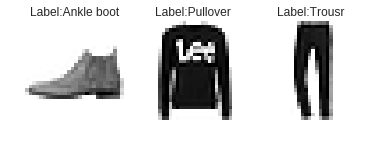

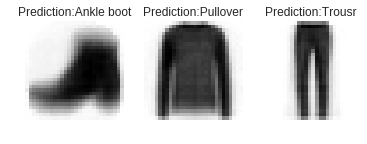

In [28]:
import matplotlib.pyplot as plt
print("Step2: Testing the performance of model on the Test Set")
test(model)
print ("Step3: Raaeconstructing some sample images")
reconstruct_sample(model,n_samples =3)